# Setup

In [9]:
from Data.data_dicts import character_dict
from Data.data_dicts import random_state
import pandas as pd
from tqdm import tqdm
import re
import numpy as np
import matplotlib.pyplot as plt

In [4]:
characters = list(character_dict.keys())
characters.remove('Default')

In [5]:
# Mount google drive, if in Colaboratory environment
import os
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive',force_remount=True)
    base_folder = '/content/drive/My Drive/unibo/NLP_project/BarneyBot'
    os.system("pip install datasets")
    os.system("pip install transformers")
    os.system("pip install rouge_score")
    os.system("pip install -U sentence-transformers")
else:
    base_folder = os.getcwd()

# Define input and output folders for chosen character
in_folder = os.path.join(base_folder, 'Data', 'Characters')
if not os.path.exists(in_folder):
    os.makedirs(in_folder)

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords

In [7]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     c:\Users\User\anaconda3\envs\nlp\lib\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [20]:
character_docs = dict()
for character in characters:
    df = pd.read_csv(os.path.join(in_folder, character, f'{character}.csv'))
    df_train, df_test = train_test_split(df, test_size=0.33, random_state=random_state)
    character_docs[character] = {'train': df_train['response'].tolist(), 
                                 'test':  df_test['response'].tolist()}

In [21]:
len(character_docs['Vader']['train']), len(character_docs['Vader']['test'])

(107, 53)

In [22]:
for character in tqdm(characters):
    for i in range(len(character_docs[character]['train'])):
        character_docs[character]['train'][i] = re.sub(r'[^A-Za-z\s]', ' ', character_docs[character]['train'][i])
        character_docs[character]['train'][i] = re.sub(r'\s+', ' ', character_docs[character]['train'][i])
    for i in range(len(character_docs[character]['test'])):
        character_docs[character]['test'][i] = re.sub(r'[^A-Za-z\s]', ' ', character_docs[character]['test'][i])
        character_docs[character]['test'][i] = re.sub(r'\s+', ' ', character_docs[character]['test'][i])

100%|██████████| 8/8 [00:00<00:00, 27.12it/s]


In [23]:
def filter_by_weights(wordweights, mass):
    N = sum([v for v in wordweights.values()])
    # N = sum(wordweights.values())
    n = 0
    filteredfreq = dict()
    for key, value in sorted(wordweights.items(), key=lambda k: k[1], reverse=True):
        n += value
        if n / N < mass:
            filteredfreq[key] = value
    return filteredfreq

# Word Frequency

In [24]:
# def get_word_frequency(doc, f_sorted=True):
#     wordlist = doc.lower().split()
#     _temp = list()
#     words = set(wordlist)
#     # wordfreq = {w: wordlist.count(w) for w in words}
#     wordfreq = {}
#     for w in wordlist:
#         wordfreq[w] = wordfreq.get(w, 0) +1
#     orderedfreq = dict()
#     print("Removing stopwords")
#     for k, v in tqdm(sorted(wordfreq.items(), key=lambda k: k[1], reverse=True)):
#         if k not in stopwords.words():
#             orderedfreq[k] = v
#     return orderedfreq

In [25]:
def get_word_frequency(doc, f_sorted=False):
    wordlist = doc.lower().split()
    _temp = list()
    words = set(wordlist)
    wordfreq = {w: wordlist.count(w) for w in words - set(stopwords.words())}
    if f_sorted:
        wordfreq = dict(sorted(wordfreq.items(), key=lambda k: k[1], reverse=True))
    return wordfreq

In [26]:
wordfreqs_train = dict()
for character in tqdm(characters):
    wordfreqs_train[character] = get_word_frequency(' '.join(character_docs[character]['train']), f_sorted=True)

wordfreqs_test = dict()
for character in tqdm(characters):
    wordfreqs_test[character] = get_word_frequency(' '.join(character_docs[character]['test']), f_sorted=True)

100%|██████████| 8/8 [00:12<00:00,  1.51s/it]


In [27]:
wordfreqs_reduced_train = dict()
for character in characters:
    wordfreqs_reduced_train[character] = filter_by_weights(wordfreqs_train[character], mass=0.3)

wordfreqs_reduced_test = dict()
for character in characters:
    wordfreqs_reduced_test[character] = filter_by_weights(wordfreqs_test[character], mass=0.3)

# TF-IDF

In [51]:
tfidf_vectorizer = TfidfVectorizer(input='content', stop_words='english')

def get_tfidfs(docs, characters, vectorizer):
    tfidf_matrix = vectorizer.fit_transform(docs)
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=characters, columns=vectorizer.get_feature_names_out())
    tfidfs = dict()
    # for character in characters:
    #     tfidf_char = tfidf_df.loc[character].to_dict()
    #     tfidfs[character] = dict()
    #     for key, value in sorted(tfidf_char.items(), key=lambda k: k[1], reverse=True):
    #         tfidfs[character][key] = value

    for i in range(len(characters)):
        tfidf_char = tfidf_df.loc[characters[i]].to_dict()
        tfidfs[characters[i]] = dict(sorted(tfidf_char.items(), key=lambda k: k[1], reverse=True))
    return tfidfs

In [29]:
tfidfs = get_tfidfs([' '.join(character_docs[character]['train']) for character in characters], characters, tfidf_vectorizer)

c:\Users\User\anaconda3\envs\nlp\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [31]:
tfidfs_reduced = dict()
for character in characters:
    tfidfs_reduced[character] = filter_by_weights(tfidfs[character], mass=0.3)

# WordCloud Plot

In [32]:
from wordcloud import WordCloud

def plot_word_cloud(freqdict, cmap='viridis', title=None, plot=False):
    wordcloud = WordCloud(background_color = 'black', width = 800, height = 400,
                      colormap = cmap, max_words = 180, contour_width = 3,
                      max_font_size = 80, contour_color = 'steelblue',
                      random_state = 0)

    wordcloud.generate_from_frequencies(freqdict)
    if title:
        plt.title(title)
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off")
    plt.figure()

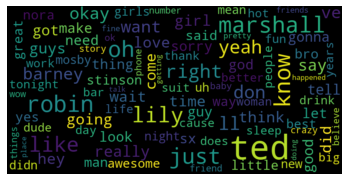

<Figure size 432x288 with 0 Axes>

In [33]:
plot_word_cloud(tfidfs_reduced['Barney'])

# Frequency Pairwise Similarity

In [34]:
from sklearn.metrics.pairwise import cosine_similarity

def freq_pairwise_sim(v1, v2):
    wordset = set(v1.keys()).union((v2.keys()))
    v1_ord = list()
    v2_ord = list()
    for w in wordset:
        v1_ord.append(v1.get(w, 0.0))
        v2_ord.append(v2.get(w, 0.0))
    return cosine_similarity(np.array(v1_ord).reshape(1, -1), np.array(v2_ord).reshape(1, -1))[0][0]

In [35]:
freq_pairwise_sim(tfidfs_reduced['Fry'], tfidfs_reduced['Barney'])

0.4133895539314938

# Frequency Classifier

In [36]:
class FrequencyChatbotClassifier:
    def __init__(self, characters, mode):
        self.characters = characters
        if mode != "word frequency" and mode != "tf-idf":
            raise Exception("Unknown mode!")
        self.mode = mode
        self.loaded = False
        self.model = None
    
    def train(self, docs):
        self.model = None
        self.loaded = False
        if len(docs) != len(self.characters):
            raise Exception("Mismatch between classifier classes and provided documents!")
        docs = [' '.join(doc) for doc in docs]
        if self.mode == 'word frequency':
            self.model = dict()
            for i in range(len(self.characters)):
                self.model[self.characters[i]] = get_word_frequency(docs[i])
        elif self.mode == 'tf-idf':
            self.model = {'vectorizer': TfidfVectorizer(input='content', stop_words='english'), 'docs': docs}
        self.loaded = True
    
    def predict(self, doc, mass=0.5):
        if not self.loaded:
            raise Exception("Classifier must be trained first!")
        doc = ' '.join(doc)
        predictions = dict()
        if self.mode == 'word frequency':
            v1 = filter_by_weights(get_word_frequency(doc), mass)
        elif self.mode == 'tf-idf':
            doc_names = self.characters.copy()
            doc_names.append('input')
            all_docs = self.model['docs'].copy()
            all_docs.append(doc)
            tfidfs = get_tfidfs(all_docs, doc_names, self.model['vectorizer'])
            v1 = filter_by_weights(tfidfs['input'], mass)
        for character in self.characters:
            if self.mode == 'word frequency':
                w = self.model[character]
            elif self.mode == 'tf-idf':
                w = tfidfs[character]
            v2 = filter_by_weights(w, mass)
            predictions[character] = freq_pairwise_sim(v1, v2)
        return predictions

In [37]:
wf_classifier = FrequencyChatbotClassifier(characters, mode='word frequency')
# wf_classifier.train(list(character_docs.values()))
wf_classifier.train([character_docs[character]['train'] for character in characters])
print(wf_classifier.predict(character_docs['Barney']['test'], mass=0.3))

{'Barney': 0.924398197913977, 'Sheldon': 0.32546651420880673, 'Harry': 0.13099111331864075, 'Fry': 0.3732207207118657, 'Bender': 0.41966027330821776, 'Vader': 0.02629830019894697, 'Joey': 0.43422420815096757, 'Phoebe': 0.48552735265916197}


In [38]:
tfidf_classifier = FrequencyChatbotClassifier(characters, mode='tf-idf')
tfidf_classifier.train([character_docs[character]['train'] for character in characters])
print(tfidf_classifier.predict(character_docs['Barney']['test'], mass=0.3))

c:\Users\User\anaconda3\envs\nlp\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


{'Barney': 0.967449878872111, 'Sheldon': 0.3501828140753443, 'Harry': 0.20554585232510325, 'Fry': 0.4359148997253555, 'Bender': 0.5016651806813825, 'Vader': 0.02215530713338878, 'Joey': 0.4896204253792704, 'Phoebe': 0.5027985609278234}


# Test performances

In [40]:
from sklearn.metrics import confusion_matrix

## Word Frequency

In [53]:
wf_classifier = FrequencyChatbotClassifier(characters, mode='word frequency')
# wf_classifier.train(list(character_docs.values()))
wf_classifier.train([character_docs[character]['train'] for character in characters])

In [54]:
y_true = range(0, len(characters))
y_pred = [np.argmax(list(wf_classifier.predict(character_docs[character]['test'], mass=0.3).values())
                    ) for character in characters]

In [55]:
confusion_matrix(y_true, y_pred)

array([[1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 1]], dtype=int64)

## TF-IDF

In [43]:
wf_classifier = FrequencyChatbotClassifier(characters, mode='tf-idf')
# wf_classifier.train(list(character_docs.values()))
wf_classifier.train([character_docs[character]['train'] for character in characters])

In [52]:
y_true = range(0, len(characters))
y_pred = [np.argmax(list(wf_classifier.predict(character_docs[character]['test'], mass=0.3).values())
                    ) for character in characters]

[0, 1, 2, 3, 4, 5, 6, 7]

In [50]:
confusion_matrix(y_true, y_pred)

array([[1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 1]], dtype=int64)